# TABLE OF CONTENTS:
---
* [Workspace](#Workspace)
* [Model](#Model)
* [Inference Environment](#Inference-Environment)
* [Inference Artifacts & Configuration](#Inference-Artifacts-&-Configuration)
* [Model Deployment](#Model-Deployment)
* [Model Testing](#Model-Testing)
* [Resource Clean Up](#Resource-Clean-Up)
---

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import uuid
from azureml.core import Environment, Workspace
from azureml.core.compute import AksCompute, ComputeTarget
from azureml.core.compute_target import ComputeTargetException
from azureml.core.container_registry import RegistryIdentity
from azureml.core.model import InferenceConfig, Model
from azureml.core.webservice import AciWebservice, AksWebservice, Webservice

# Workspace

### Option 1: Create Workspace from Config

In [12]:
ws = Workspace.from_config() # this automatically looks for a directory .azureml

# ws.get_details()

### Option 2: Create Workspace from Connection Info

In [13]:
# ws = Workspace.get(name="sbirk-aml-ws",
#                    subscription_id="bf088f59-f015-4332-bd36-54b988be7c90",
#                    resource_group="sbirk-aml-rg")     
#
# ws.get_details()

# Model

### Retrieve Registered Model from Workspace

In [14]:
model_name = "cifar10-model"
model = Model(workspace=ws, name=model_name)

# Inference Environment

### Option 1: Retrieve Environment from Workspace

In [15]:
env_name = "pytorch-aml-env"
env = Environment.get(workspace=ws, name=env_name)

### Option 2: Create New Environment

In [24]:
env = Environment.from_conda_specification(name="pytorch-aml-env",
                                           file_path="../environments/conda/environment.yml")

# Attribute docker.enabled controls whether to use Docker container or host OS for execution.
# This is only relevant for local execution as execution on AML Compute Cluster will always use Docker container.
# env.docker.enabled = True

# Use Python dependencies from your Docker image (as opposed to from conda specification)
# env.python.user_managed_dependencies=True

## Only uncomment one of the three below options
# OPTION 1: Use mcr base image
env.docker.base_image = "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1"
#env.docker.base_image = 'mcr.microsoft.com/azureml/openmpi3.1.2-cuda10.1-cudnn7-ubuntu18.04' # GPU base image

# **Option 2**: Use custom base image from workspace-native ACR
# env.docker.base_image = "eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io/base/pytorch"

# OPTION 3: Use custom base image from standalone ACR and use admin user credentials. For this you need to enable admin user in the ACR.
#env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
#env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
#env.docker.base_image_registry.username = "sbirkacr"
#env.docker.base_image_registry.password = "HqAu5Y2We0gZ42IunR5MBXkKc+shf2uj" # replace with Key Vault

# Option 4: Use custom base image from standalone ACR and use service principal authentication. 
#           The service principal needs the AcrPull RBAN on the standalone ACR.
# keyvault = ws.get_default_keyvault()
# env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
# env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
# env.docker.base_image_registry.username = keyvault.get_secret(name="sbirk-acr-sp-username")
# env.docker.base_image_registry.password = keyvault.get_secret(name="sbirk-acr-sp-password")

# **Option 5**: Use custom base image from standalone ACR with anonymous access preview feature.
# env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"

# **Option 6**: Use custom base image from standalone ACR with user-managed identity authentication.
# https://docs.microsoft.com/en-us/azure/active-directory/managed-identities-azure-resources/how-to-manage-ua-identity-portal#:~:text=%20Name%3A%20This%20is%20the%20name%20for%20your,deploy%20the%20user-assigned%20managed%20identity%2C%20for...%20More%20
# The user-managed identity needs at least AcrPull RBAC on the standalone ACR.
# This requires 521 RBAC as well for docker commands from the terminal
#env.docker.base_image = "sbirkacr.azurecr.io/base/pytorch"
#env.docker.base_image_registry.address = "sbirkacr.azurecr.io"
#env.docker.base_image_registry.registry_identity = RegistryIdentity()
#env.docker.base_image_registry.registry_identity.resource_id = "/subscriptions/bf088f59-f015-4332-bd36-54b988be7c90/resourceGroups/sbirk-aml-rg/providers/Microsoft.ManagedIdentity/userAssignedIdentities/sbirk-uami"
#env.docker.base_image_registry.registry_identity.client_id = "155d77a8-3a1d-4b45-8a04-e618418f1624"

# Create an environment variable.
# This can be retrieved in the training script with os.environ.get("MESSAGE").
# env.environment_variables = {"MESSAGE": "Hello from Azure Machine Learning"}

env.inferencing_stack_version = "latest"
# This will install the inference specific apt packages. This is needed for inferencing images.

env.register(workspace=ws)

{
    "databricks": {
        "eggLibraries": [],
        "jarLibraries": [],
        "mavenLibraries": [],
        "pypiLibraries": [],
        "rcranLibraries": []
    },
    "docker": {
        "arguments": [],
        "baseDockerfile": null,
        "baseImage": "mcr.microsoft.com/azureml/intelmpi2018.3-ubuntu16.04:20201113.v1",
        "baseImageRegistry": {
            "address": null,
            "password": null,
            "registryIdentity": null,
            "username": null
        },
        "enabled": false,
        "platform": {
            "architecture": "amd64",
            "os": "Linux"
        },
        "sharedVolumes": true,
        "shmSize": null
    },
    "environmentVariables": {
        "EXAMPLE_ENV_VAR": "EXAMPLE_VALUE"
    },
    "inferencingStackVersion": "latest",
    "name": "pytorch-aml-env-2",
    "python": {
        "baseCondaEnvironment": null,
        "condaDependencies": {
            "channels": [
                "pytorch"
            ],
       

# Inference Artifacts & Configuration

In [25]:
deployment_folder = os.path.join("../src/", "deployment")
os.makedirs(deployment_folder, exist_ok=True)

Create the scoring script, called score.py, used by the web service call to show how to use the model.

You must include two required functions into the scoring script:
* The `init()` function, which typically loads the model into a global object. This function is run only once when the Docker container is started. 

* The `run(input_data)` function uses the model to predict a value based on the input data. Inputs and outputs to the run typically use JSON for serialization and de-serialization, but other formats are supported.

The [*scoring script*](score.py) file is has two functions:

1. an `init` function that executes once when the service starts - in this function you normally get the model from the registry and set global variables
1. a `run(data)` function that executes each time a call is made to the service. In this function, you normally deserialize the json, run a prediction and output the predicted result.

In [26]:
%%writefile $deployment_folder/score.py
import os
import torch
import json
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def init():
    global net
    global classes

    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_filename = "cifar_net.pt"
    model_path = os.path.join(os.environ['AZUREML_MODEL_DIR'], model_filename)
    net = Net()
    net.load_state_dict(torch.load(model_path))
    classes = ('plane', 'car', 'bird', 'cat',
               'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


def run(data):
    data = json.loads(data)
    images = torch.FloatTensor(data['data'])
    outputs = net(images)

    _, predicted = torch.max(outputs, 1)

    result = [classes[predicted[j]] for j in range(4)]
    result_json = json.dumps({"predictions": result})

    # You can return any JSON-serializable object.
    return result_json

Overwriting ../src/deployment/score.py


In [27]:
# Create Inference Config
inference_config = InferenceConfig(entry_script="../src/deployment/score.py",
                                   environment=env)

# Deployment

## Option 1: Package Models

[Package a registered model with docker](https://docs.microsoft.com/en-us/azure/machine-learning/how-to-deploy-package-models):

In some cases, you might want to create a Docker image without deploying the model (if, for example, you plan to deploy to Azure App Service). Or you might want to download the image and run it on a local Docker installation. You might even want to download the files used to build the image, inspect them, modify them, and build the image manually.

Model packaging enables you to do these things. It packages all the assets needed to host a model as a web service and allows you to download either a fully built Docker image or the files needed to build one. There are two ways to use model packaging:

**Download a packaged model:** Download a Docker image that contains the model and other files needed to host it as a web service.

**Generate a Dockerfile:** Download the Dockerfile, model, entry script, and other assets needed to build a Docker image. You can then inspect the files or make changes before you build the image locally.

Creating a package is similar to deploying a model. You use a registered model and an inference configuration. The following code builds an image, which is registered in the Azure Container Registry for your workspace.

In [28]:
image_name = "inference/cifar10-pytorch"
image_label = "1.0" # image tag
generate_dockerfile = True # Option 1: False -> Build Image on ACR; Option 2: True -> Only create Dockerfile


# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=generate_dockerfile,
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

Package creation Failed


WebserviceException: WebserviceException:
	Message: Package creation reached non-successful terminal state.
State: Failed
Error:
StatusCode: 400
Message: Failed to fetch details for Environment with Name: pytorch-aml-env-2 Version: Autosave_2021-01-14T19:47:10Z_b23bd259 Reason: Unable to resolve Container Registry: eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io. If private link is enabled in workspace, please verify ACR is part of private link.  For additional information see: https://aka.ms/azureml-privatelink.

	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Package creation reached non-successful terminal state.\nState: Failed\nError:\nStatusCode: 400\nMessage: Failed to fetch details for Environment with Name: pytorch-aml-env-2 Version: Autosave_2021-01-14T19:47:10Z_b23bd259 Reason: Unable to resolve Container Registry: eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io. If private link is enabled in workspace, please verify ACR is part of private link.  For additional information see: https://aka.ms/azureml-privatelink.\n"
    }
}

In [30]:
image_name = "inference/cifar10-pytorch"
image_label = "1.0" # image tag
generate_dockerfile = False # Option 1: False -> Build Image on ACR; Option 2: True -> Only create Dockerfile


# Creating package
package = Model.package(ws, 
                        [model], 
                        inference_config=inference_config, 
                        generate_dockerfile=generate_dockerfile,
                        image_name=image_name,
                        image_label=image_label)

package.wait_for_creation(show_output=True)

Package creation Failed


WebserviceException: WebserviceException:
	Message: Package creation reached non-successful terminal state.
State: Failed
Error:
StatusCode: 400
Message: Failed to fetch details for Environment with Name: pytorch-aml-env-2 Version: Autosave_2021-01-14T19:47:10Z_b23bd259 Reason: Unable to resolve Container Registry: eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io. If private link is enabled in workspace, please verify ACR is part of private link.  For additional information see: https://aka.ms/azureml-privatelink.

	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Package creation reached non-successful terminal state.\nState: Failed\nError:\nStatusCode: 400\nMessage: Failed to fetch details for Environment with Name: pytorch-aml-env-2 Version: Autosave_2021-01-14T19:47:10Z_b23bd259 Reason: Unable to resolve Container Registry: eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io. If private link is enabled in workspace, please verify ACR is part of private link.  For additional information see: https://aka.ms/azureml-privatelink.\n"
    }
}

After you create a package, you can use package.pull() to pull the image to your local Docker environment. This can only be used if `generate_dockerfile` is set to `False`. When the package is pulled, use the `docker images` command to list the local images.

In [46]:
# package.pull()

To start a local container based on this image, use the following command to start a named container from the shell or command line. Replace the `<imageid>` value with the image ID returned by the docker images command.

`docker run -p 6789:5001 --name mycontainer <imageid>`

This command starts the latest version of the image named `myimage`. It maps local port 6789 to the port in the container on which the web service is listening (5001). It also assigns the name mycontainer to the container, which makes the container easier to stop. After the container is started, you can submit requests to http://localhost:6789/score.

After you create a Dockerfile, you can use package.save() to download the Dockerfile and corresponding artifacts to your local machine. This can only be used if `generate_dockerfile` is set to `True`.

In [47]:
acr = package.get_container_registry()
print("Address:", acr.address)
print("Username:", acr.username)
print("Password:", acr.password)

Address: eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io
Username: eafc0c3ef9714c74a4fa655ee90531ba
Password: QYPVrNglB0VvrUrEVMhWar5U4wT4G/tP


In [48]:
package.save("../environments/docker/")

Logging into Docker registry eafc0c3ef9714c74a4fa655ee90531ba.azurecr.io


## Local Image Build

In [20]:
#!docker login <address> -u <username> -p <password>
#!cd environments/docker
#!docker build --tag cifar10-pytorch <imagefiles> 
#!docker images

In [21]:
# Remove docker images
#!docker image rm <image_id>

## Local Image Deployment

In [22]:
#!docker run -p 6789:5001 --name cifar10-pytorch-container cifar10-pytorch:latest

## Push Image to ACR

In [ ]:
# Tag image with fully qualified path
#!docker tag cifar10-pytorch 5c5bd98e724841e884500ebf807070c9.azurecr.io/inference/cifar10-pytorch
# Push image
#!docker push 5c5bd98e724841e884500ebf807070c9.azurecr.io/inference/cifar10-pytorch

In [ ]:
#!az acr build --image inference/acrtasktest:1.0 --registry eafc0c3ef9714c74a4fa655ee90531ba .

## Option 2: Deploy to Compute Target

### Option 1: Azure Container Instances

The next cell deploys the model to an Azure Container Instance so that you can score data in real-time (Azure Machine Learning also provides mechanisms to do batch scoring). A real-time endpoint allows application developers to integrate machine learning into their apps.


In [13]:
aci_config = AciWebservice.deploy_configuration(cpu_cores=1,
                                                memory_gb=1,
                                                tags={"data": "Cifar",  "method" : "Pytorch"},
                                                description="Predict cifar images with a Pytorch CNN")

In [15]:
service_name = "cifar-prediction-service"

service = Model.deploy(workspace=ws,
                       name=service_name,
                       models=[model],
                       inference_config=inference_config,
                       deployment_config=aci_config,
                       overwrite=True)
service.wait_for_deployment(show_output=True)

Tips: You can try get_logs(): https://aka.ms/debugimage#dockerlog or local deployment: https://aka.ms/debugimage#debug-locally to debug if deployment takes longer than 10 minutes.
Running...............................................................
Succeeded
ACI service creation operation finished, operation "Succeeded"


In [16]:
print(service.scoring_uri)

http://9f464353-ae45-45be-b801-5112e33cafe2.westeurope.azurecontainer.io/score


### Option 2: Azure Kubernetes Service

#### Option 2.1: Provisioning New AKS Cluster

In [ ]:
# Choose a name for your AKS cluster
aks_name = "my-test-aks"

# Verify that cluster does not exist already
try:
    aks_target = ComputeTarget(workspace=ws, name=aks_name)
    print("Found existing cluster, use it.")
except ComputeTargetException:
    # Use the default configuration (you can also provide parameters to customize this).
    # For example, to create a dev/test cluster, use:
    prov_config = AksCompute.provisioning_configuration(cluster_purpose = AksCompute.ClusterPurpose.DEV_TEST)
    # prov_config = AksCompute.provisioning_configuration()

    # Example configuration to use an existing virtual network
    # prov_config.vnet_name = "mynetwork"
    # prov_config.vnet_resourcegroup_name = "mygroup"
    # prov_config.subnet_name = "default"
    # prov_config.service_cidr = "10.0.0.0/16"
    # prov_config.dns_service_ip = "10.0.0.10"
    # prov_config.docker_bridge_cidr = "172.17.0.1/16"

    # Create the cluster
    aks_target = ComputeTarget.create(workspace = ws,
                                      name = aks_name,
                                      provisioning_configuration = prov_config)

if aks_target.get_status() != "Succeeded":
    aks_target.wait_for_completion(show_output=True)

## Option 2: Attaching

In [ ]:
aks_target_name = "newaksinf04"
aks_target = AksCompute(workspace=ws, name=aks_target_name)
print(aks_target.get_status())

In [ ]:
aks_service_name ="newendpoint06"
aks_config = AksWebservice.deploy_configuration(cpu_cores = 1, memory_gb = 4)

In [ ]:
%%time
aks_service = Model.deploy(workspace=ws,
                           name=aks_service_name,
                           models=[model],
                           inference_config=inference_config,
                           deployment_config=aks_config,
                           deployment_target=aks_target)

aks_service.wait_for_deployment(show_output = True)
print(aks_service.state)

# Data

In [23]:
# Define transformation steps
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]) # mean, variance of channels

# Create test dataset and dataloader
testset = torchvision.datasets.CIFAR10(root="../data", train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

Files already downloaded and verified


# Model Testing

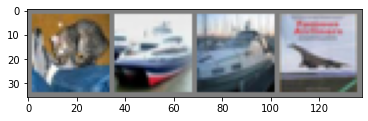

GroundTruth: 
        cat        ship        ship       plane


In [24]:
def imshow(img):
    img = img / 2 + 0.5 # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # transpose dimensions from Pytorch format to default numpy format
    plt.show()
    
# Define classes
classes = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print("GroundTruth: ", " ".join("%11s" % classes[labels[j]] for j in range(4)), sep="\n")

In [30]:
import json

input_payload = json.dumps({
    "data": images.tolist()
})

output = service.run(input_payload)
print(output)

{"predictions": ["ship", "ship", "ship", "ship"]}


## Test Local Container

In [25]:
import requests
import json

# URL for the web service.
scoring_uri = "http://localhost:6789/score"

input_payload = json.dumps({
    "data": images.tolist()
})

# Set the content type.
headers = {'Content-Type': 'application/json'}

# Make the request and display the response.
resp = requests.post(scoring_uri, input_payload, headers=headers)
print(resp.text)

"{\"predictions\": [\"cat\", \"car\", \"plane\", \"plane\"]}"


In [ ]:
!#docker kill cifar10-pytorch-container

# Resource Clean Up

In [ ]:
service.delete()

In [ ]:
%%time
env = Environment.get(workspace=ws, name="pytorch-aml-env")

inference_config = InferenceConfig(entry_script="deployment/score.py",
                                   environment=env)

service_name = "Cifar-pytorch-service" + str(uuid.uuid4())[:4]

service = Model.deploy(workspace=ws, 
                       name=service_name, 
                       models=[model], 
                       inference_config=inference_config, 
                       deployment_config=aci_config)

service.wait_for_deployment(show_output=True)

# Test the model

In [ ]:
from utils import load_data
import os
import glob

data_folder = os.path.join(os.getcwd(), 'data')
# note we also shrink the intensity values (X) from 0-255 to 0-1. This helps the neural network converge faster
X_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-images-idx3-ubyte.gz"), recursive=True)[0], False) / 255.0
y_test = load_data(glob.glob(os.path.join(data_folder,"**/t10k-labels-idx1-ubyte.gz"), recursive=True)[0], True).reshape(-1)

In [ ]:
import os
from azureml.core import Dataset
from azureml.opendatasets import MNIST

data_folder = os.path.join(os.getcwd(), 'data')
os.makedirs(data_folder, exist_ok=True)

mnist_file_dataset = MNIST.get_file_dataset()
mnist_file_dataset.download(data_folder, overwrite=True)

In [ ]:
import json
test = json.dumps({"data": X_test.tolist()})
test = bytes(test, encoding='utf8')
y_hat = service.run(input_data=test)

In [ ]:
from sklearn.metrics import confusion_matrix

conf_mx = confusion_matrix(y_test, y_hat)
print(conf_mx)
print('Overall accuracy:', np.average(y_hat == y_test))

In [ ]:
# normalize the diagonal cells so that they don't overpower the rest of the cells when visualized
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111)
cax = ax.matshow(norm_conf_mx, cmap=plt.cm.bone)
ticks = np.arange(0, 10, 1)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(ticks)
ax.set_yticklabels(ticks)
fig.colorbar(cax)
plt.ylabel('true labels', fontsize=14)
plt.xlabel('predicted values', fontsize=14)
plt.savefig('conf.png')
plt.show()

In [ ]:
import json

# find 30 random samples from test set
n = 30
sample_indices = np.random.permutation(X_test.shape[0])[0:n]

test_samples = json.dumps({"data": X_test[sample_indices].tolist()})
test_samples = bytes(test_samples, encoding='utf8')

# predict using the deployed model
result = service.run(input_data=test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x=10, y =-10, s=result[i], fontsize=18, color=font_color)
    plt.imshow(X_test[s].reshape(28, 28), cmap=clr_map)
    
    i = i + 1
plt.show()

### Send HTTP request with the Python requests library

In [ ]:
import requests

# send a random row from the test set to score
random_index = np.random.randint(0, len(X_test)-1)
input_data = "{\"data\": [" + str(list(X_test[random_index])) + "]}"

headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 

resp = requests.post(service.scoring_uri, input_data, headers=headers)

print("POST to url", service.scoring_uri)
#print("input data:", input_data)
print("label:", y_test[random_index])
print("prediction:", resp.text)

In [ ]:
service.delete()

Now, you're ready to deploy the model as a web service in [Azure Container Instances](https://docs.microsoft.com/azure/container-instances/) (ACI). A web service is an image, in this case a Docker image, that encapsulates the scoring logic and the model itself. 

ACI is a great solution for testing and understanding the workflow. For scalable production deployments, consider using Azure Kubernetes Service.

In [ ]:
#### Install Homomorphic Encryption based library for Secure Inferencing

Our library is based on [Microsoft SEAL](https://github.com/Microsoft/SEAL) and pubished to [PyPi.org](https://pypi.org/project/encrypted-inference) as an easy to use package 

In [ ]:
# !pip install encrypted-inference==0.9

In [ ]:
%%writefile score.py
import json
import os
import pickle
import joblib
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient, PublicAccess
from encrypted.inference.eiserver import EIServer

def init():
    global model
    # AZUREML_MODEL_DIR is an environment variable created during deployment.
    # It is the path to the model folder (./azureml-models/$MODEL_NAME/$VERSION)
    # For multiple models, it points to the folder containing all deployed models (./azureml-models)
    model_path = os.path.join(os.getenv('AZUREML_MODEL_DIR'), 'sklearn_mnist_model.pkl')
    model = joblib.load(model_path)

    global server
    server = EIServer(model.coef_, model.intercept_, verbose=True)

def run(raw_data):

    json_properties = json.loads(raw_data)

    key_id = json_properties['key_id']
    conn_str = json_properties['conn_str']
    container = json_properties['container']
    data = json_properties['data']

    # download the Galois keys from blob storage
    #TODO optimize by caching the keys locally  
    blob_service_client = BlobServiceClient.from_connection_string(conn_str=conn_str)
    blob_client = blob_service_client.get_blob_client(container=container, blob=key_id)
    public_keys = blob_client.download_blob().readall()
    
    result = {}
    # make prediction
    result = server.predict(data, public_keys)

    # you can return any data type as long as it is JSON-serializable
    return result

In [ ]:
### Predict test data

Feed the test dataset to the model to get predictions.


The following code goes through these steps:

1. Create our Homomorphic Encryption based client 

1. Upload HE generated public keys 

1. Encrypt the data

1. Send the data as JSON to the web service hosted in ACI. 

1. Use the SDK's `run` API to invoke the service. You can also make raw calls using any HTTP tool such as curl.

In [ ]:
#### Create our Homomorphic Encryption based client 

Create a new EILinearRegressionClient and setup the public keys 

In [ ]:
from encrypted.inference.eiclient import EILinearRegressionClient

# Create a new Encrypted inference client and a new secret key.
edp = EILinearRegressionClient(verbose=True)

public_keys_blob, public_keys_data = edp.get_public_keys()


In [ ]:
#### Upload HE generated public keys

Upload the public keys to the workspace default blob store. This will allow us to share the keys with the inference server

In [ ]:
import azureml.core
from azureml.core import Workspace, Datastore
import os

ws = Workspace.from_config()

datastore = ws.get_default_datastore()
container_name=datastore.container_name

# Create a local file and write the keys to it
public_keys = open(public_keys_blob, "wb")
public_keys.write(public_keys_data)
public_keys.close()

# Upload the file to blob store
datastore.upload_files([public_keys_blob])

# Delete the local file
os.remove(public_keys_blob)

In [ ]:
#### Encrypt the data 

In [ ]:
#choose any one sample from the test data 
sample_index = 1

#encrypt the data
raw_data = edp.encrypt(X_test[sample_index])


In [ ]:
#### Send the test data to the webservice hosted in ACI

Feed the test dataset to the model to get predictions. We will need to send the connection string to the blob storage where the public keys were uploaded 


In [ ]:
import json
from azureml.core import Webservice

service = Webservice(ws, service_name)

#pass the connection string for blob storage to give the server access to the uploaded public keys 
conn_str_template = 'DefaultEndpointsProtocol={};AccountName={};AccountKey={};EndpointSuffix=core.windows.net'
conn_str = conn_str_template.format(datastore.protocol, datastore.account_name, datastore.account_key)

#build the json 
data = json.dumps({"data": raw_data, "key_id" : public_keys_blob, "conn_str" : conn_str, "container" : container_name })
data = bytes(data, encoding='ASCII')

print ('Making an encrypted inference web service call ')
eresult = service.run(input_data=data)

print ('Received encrypted inference results')

In [ ]:
#### Decrypt the data

Use the client to decrypt the results

In [ ]:
import numpy as np 

results = edp.decrypt(eresult)

print ('Decrypted the results ', results)

#Apply argmax to identify the prediction result
prediction = np.argmax(results)

print ( ' Prediction : ', prediction)
print ( ' Actual Label : ', y_test[sample_index])

In [ ]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [ ]:
import json

input_payload = json.dumps({
    'data': images.tolist()
})

output = service.run(input_payload)
print(output)

It is often the case that once you have your machine learning code working in a development environment that you want to productionize this by running as a **_job_** - ideally on a schedule or trigger (for example, arrival of new data).